# Contents
1. [Import and request the data](#Import-and-request-the-data)
2. [EDA](#EDA) 
    * [Feature engineering and dealing with missing values](#Feature-engineering-and-dealing-with-missing-values)
3. [Text columns preparation](#Text-columns-preparation)
4. [Lemmatisation (NLTK)](#Lemmatisation-(NLTK))
5. [Word2Vec](#Word2Vec)
6. [Visualization: t-SNE](#Visualization:-t-SNE)
7. [Benchmark model: XGBoost. Without images. Not done](#Benchmark-model:-XGBoost.-Without-images.-Not-done)
8. [Imgages Preparation for PyTorch. In progress](#Imgages-Preparation-for-PyTorch.-In-progress)

## Import and request the data

In [4]:
import numpy as np
import pandas
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# create a client instance of the library
elastic_client = Elasticsearch(timeout=60, max_retries=10, retry_on_timeout=True)
elastic_client.cluster.health(wait_for_status='yellow', request_timeout=55)

{'cluster_name': 'es-docker-cluster',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 10,
 'active_shards': 10,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 1,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 90.9090909090909}

In [2]:
#https://kb.objectrocket.com/elasticsearch/how-to-use-elasticsearch-data-using-pandas-in-python-349
response = elastic_client.search(
    index='opensea',
    body={},
    size=1
)
response

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.0,
  'hits': [{'_index': 'opensea',
    '_type': '_doc',
    '_id': 'PY4SOX0BHA1xYJHHtcXY',
    '_score': 1.0,
    '_source': {'os_id': 106803514,
     'token_id': '6310487523167464038236848917657863475338708156820240490236251522907754201089',
     'name': 'Cool Dog #243',
     'description': None,
     'external_link': None,
     'permalink': 'https://opensea.io/assets/0x495f947276749ce646f68ac8c248420045cb7b5e/6310487523167464038236848917657863475338708156820240490236251522907754201089',
     'collection_slug': 'cool-dogs-1',
     'collection_created': '2021-08-08T04:52:47.684730',
     'collection_description': 'Cool Dogs is a limited series of 1/1 NFTs, a collection of hand drawn parody avatars. \nOnly 333 will be created, then any wallet holding 2 or more dogs will be airdropped an exclusive puppy from Cool 

In [5]:
s = Search(using=elastic_client, index="opensea") \
    .filter("exists", field="latest_sale_usd") \
    .filter("exists", field="preview_path") \
    .exclude("match", is_animation=True)
s = s.source(excludes=[
    "last_sale_orginal", "image_original_url", "image_preview_url", "image_url", "os_id",
    'animation_url', '@scraped', 'animation_original_url', 
    'permalink', 'is_animation', 'sell_order_usd', 'buy_order_usd'
])
s = s.extra(track_total_hits=True)
s = s.extra(from_=0, size=10000)
response = s.execute()
# declare a new list for the Elasticsearch documents
# nested inside the API response object
elastic_docs = response.to_dict()["hits"]["hits"]

# print number of documents
print("documents returned:", len(response["hits"]["hits"]))
print(response.hits.total)

documents returned: 10000
{'value': 32234, 'relation': 'eq'}


In [7]:
for hit in response[0:10]:
    print(hit.name)

cryptomeme.eth
#2388
Primate Social Society #8390
#979
#711
Lazy CryptoCat #824
#1167
#1611
Noundles #4847
OG:Crystal 785


In [9]:
list(response.to_dict()["hits"])[0:10]

['total', 'max_score', 'hits']

In [15]:
count = 0
# iterate over all of the docs
for key, val in response.to_dict()["hits"].items():
    if key == "hits":
        for num, doc in enumerate(val):
            print (num, '-->', doc["_source"]["name"])
            count += 1
            if count > 10:
                break

0 --> cryptomeme.eth
1 --> #2388
2 --> Primate Social Society #8390
3 --> #979
4 --> #711
5 --> Lazy CryptoCat #824
6 --> #1167
7 --> #1611
8 --> Noundles #4847
9 --> OG:Crystal 785
10 --> None


In [17]:
fields = {}
length = 0
for num, doc in enumerate(elastic_docs):
    # set id
    try:
        fields['id'] = np.append(fields['id'], doc["_id"])
    except KeyError:
        fields['id'] = np.array([doc["_id"]])
    # get source data from document
    source_data = doc["_source"]
    # iterate source data
    for key, val in source_data.items():
        try:
            fields[key] = np.append(fields[key], val)
        except KeyError:
            if length > 0:
                arr = [None] * length
                arr.append(val)
                fields[key] = np.array(arr)
            else:
                fields[key] = np.array([val])

    for key in fields.keys():
        if key not in source_data and key != 'id':
            fields[key] = np.append(fields[key], None)
    length += 1


In [7]:
for key, val in list(fields.items())[0:30]:
    print (key, "--->", len(val))

id ---> 10000
creator ---> 10000
collection_created ---> 10000
latest_sale_usd ---> 10000
description ---> 10000
@latest_sale_timestamp ---> 10000
external_link ---> 10000
twitter ---> 10000
token_id ---> 10000
img_path ---> 10000
twitter_follower ---> 10000
name ---> 10000
collection_slug ---> 10000
preview_path ---> 10000
collection_description ---> 10000
instagram ---> 10000
telegram_follower ---> 10000
telegram ---> 10000
instagram_follower ---> 10000


In [22]:
# create a Pandas DataFrame array from the fields dict
elastic_df = pandas.DataFrame(fields)

print('elastic_df:', type(elastic_df), "\n")

elastic_df: <class 'pandas.core.frame.DataFrame'> 



## EDA
### Feature engineering and dealing with missing values

In [10]:
elastic_df.head(10)

,id,creator,collection_created,latest_sale_usd,description,@latest_sale_timestamp,external_link,twitter,token_id,img_path,twitter_follower,name,collection_slug,preview_path,collection_description,instagram,telegram_follower,telegram,instagram_follower
0,rM4OQ30Bnd7hjRQyDd1Y,0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8,2019-05-08T21:59:36.282454,216.99900,"`cryptomeme.eth`, an ENS name.",2021-11-21T15:06:11,https://app.ens.domains/search/cryptomeme,https://cdn.syndication.twimg.com/widgets/foll...,7796771725932166225105739356350427289626824723...,D:\Code\datascience\opensea_scapper\opensea_nf...,115707,cryptomeme.eth,ens,D:\Code\datascience\opensea_scapper\opensea_nf...,Ethereum Name Service (ENS) domains are secure...,None,None,None,None
1,pc4NQ30Bnd7hjRQyYd1z,0xc00f4b8022e4dc7f086d703328247cb6adf26858,2021-11-21T09:55:15.388526,694.39680,None,2021-11-21T15:06:47,https://feudalz.io,None,2388,D:\Code\datascience\opensea_scapper\opensea_nf...,None,#2388,feudalz,D:\Code\datascience\opensea_scapper\opensea_nf...,Feudalz emerged to protect their Peasants. Whe...,None,None,None,None
2,pM4NQ30Bnd7hjRQyTN18,Forlane,2021-09-20T02:11:59.437808,212.65902,None,2021-11-21T15:06:47,None,https://cdn.syndication.twimg.com/widgets/foll...,8390,D:\Code\datascience\opensea_scapper\opensea_nf...,None,Primate Social Society #8390,primate-social-society-official,D:\Code\datascience\opensea_scapper\opensea_nf...,The Primate Social Society is a sophisticated ...,primatesocialsociety,None,None,None
3,ns4MQ30Bnd7hjRQywN2i,0xc00f4b8022e4dc7f086d703328247cb6adf26858,2021-11-21T09:55:15.388526,1518.99300,None,2021-11-21T15:06:47,https://feudalz.io,None,979,D:\Code\datascience\opensea_scapper\opensea_nf...,None,#979,feudalz,D:\Code\datascience\opensea_scapper\opensea_nf...,Feudalz emerged to protect their Peasants. Whe...,None,None,None,None
4,ss4OQ30Bnd7hjRQywt3k,0xc00f4b8022e4dc7f086d703328247cb6adf26858,2021-11-21T09:55:15.388526,759.49650,None,2021-11-21T15:06:11,https://feudalz.io,None,711,D:\Code\datascience\opensea_scapper\opensea_nf...,None,#711,feudalz,D:\Code\datascience\opensea_scapper\opensea_nf...,Feudalz emerged to protect their Peasants. Whe...,None,None,None,None
5,nc4MQ30Bnd7hjRQypd3q,LazyCryptoCats,2021-06-11T20:20:31.010037,130.19940,None,2021-11-21T15:06:47,None,https://cdn.syndication.twimg.com/widgets/foll...,2309538745211295593732510463759595317529580894...,D:\Code\datascience\opensea_scapper\opensea_nf...,1399,Lazy CryptoCat #824,lazycryptocats,D:\Code\datascience\opensea_scapper\opensea_nf...,"Lazy CryptoCats is a collection of 3,500 uniqu...",lazycryptocats,None,None,None
6,m84MQ30Bnd7hjRQyfd1R,0xc00f4b8022e4dc7f086d703328247cb6adf26858,2021-11-21T09:55:15.388526,1084.99500,None,2021-11-21T15:06:47,https://feudalz.io,None,1167,D:\Code\datascience\opensea_scapper\opensea_nf...,None,#1167,feudalz,D:\Code\datascience\opensea_scapper\opensea_nf...,Feudalz emerged to protect their Peasants. Whe...,None,None,None,None
7,mc4MQ30Bnd7hjRQyV91l,0xc00f4b8022e4dc7f086d703328247cb6adf26858,2021-11-21T09:55:15.388526,1301.99400,None,2021-11-21T15:06:55,https://feudalz.io,None,1611,D:\Code\datascience\opensea_scapper\opensea_nf...,None,#1611,feudalz,D:\Code\datascience\opensea_scapper\opensea_nf...,Feudalz emerged to protect their Peasants. Whe...,None,None,None,None
8,p84NQ30Bnd7hjRQyjt17,Noundles,2021-11-12T09:10:35.046659,650.99700,When nounsdaos meets doodles. Not affiliated w...,2021-11-21T15:06:47,None,https://cdn.syndication.twimg.com/widgets/foll...,4847,D:\Code\datascience\opensea_scapper\opensea_nf...,4102,Noundles #4847,noundles,D:\Code\datascience\opensea_scapper\opensea_nf...,Noundles is based on Nouns with a twist in sty...,None,None,None,None
9,ms4MQ30Bnd7hjRQyY90p,OG-Cradle,2021-10-14T02:47:29.060220,520.79760,This one-of-a-kind OG:Crystal reflects both th...,2021-11-21T15:06:55,https://ogcrystals.com,https://cdn.syndication.twimg.com/widgets/foll...,785,D:\Code\datascience\opensea_scapper\opensea_nf...,10826,OG:Crystal 785,og-crys

In [11]:
# head doesn't show all columns - so I use this here:
elastic_df.iloc[4541]

id                                                     BR1OSH0BaRL6QHS3ywjX
creator                                                      AvarikSagaTeam
collection_created                               2021-09-23T23:40:19.188743
latest_sale_usd                                                    473.8503
description               There's more to knighthood than making a mark ...
@latest_sale_timestamp                                  2021-11-22T10:09:36
external_link                                                          None
twitter                                                                None
token_id                                                               7049
img_path                           C:\nft_data\img\BR1OSH0BaRL6QHS3ywjX.jpg
twitter_follower                                                       None
name                                                    Glacian Squire #113
collection_slug                                          avariksagauniverse
preview_path

In [9]:
elastic_df['latest_sale_usd'][0:10]

0     216.99900
1     694.39680
2     212.65902
3    1518.99300
4     759.49650
5     130.19940
6    1084.99500
7    1301.99400
8     650.99700
9     520.79760
Name: latest_sale_usd, dtype: float64

In [16]:
elastic_df.columns

Index(['id', 'creator', 'collection_created', 'latest_sale_usd', 'description',
       '@latest_sale_timestamp', 'external_link', 'twitter', 'token_id',
       'img_path', 'twitter_follower', 'name', 'collection_slug',
       'preview_path', 'collection_description', 'instagram',
       'telegram_follower', 'telegram', 'instagram_follower'],
      dtype='object')

In [9]:
elastic_df.drop(['token_id'], inplace=True, axis=1)

In [18]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  object 
 1   creator                 9897 non-null   object 
 2   collection_created      10000 non-null  object 
 3   latest_sale_usd         10000 non-null  float64
 4   description             7739 non-null   object 
 5   @latest_sale_timestamp  10000 non-null  object 
 6   external_link           2701 non-null   object 
 7   twitter                 2070 non-null   object 
 8   img_path                9836 non-null   object 
 9   twitter_follower        1992 non-null   object 
 10  name                    9678 non-null   object 
 11  collection_slug         10000 non-null  object 
 12  preview_path            10000 non-null  object 
 13  collection_description  9892 non-null   object 
 14  instagram               4515 non-null  

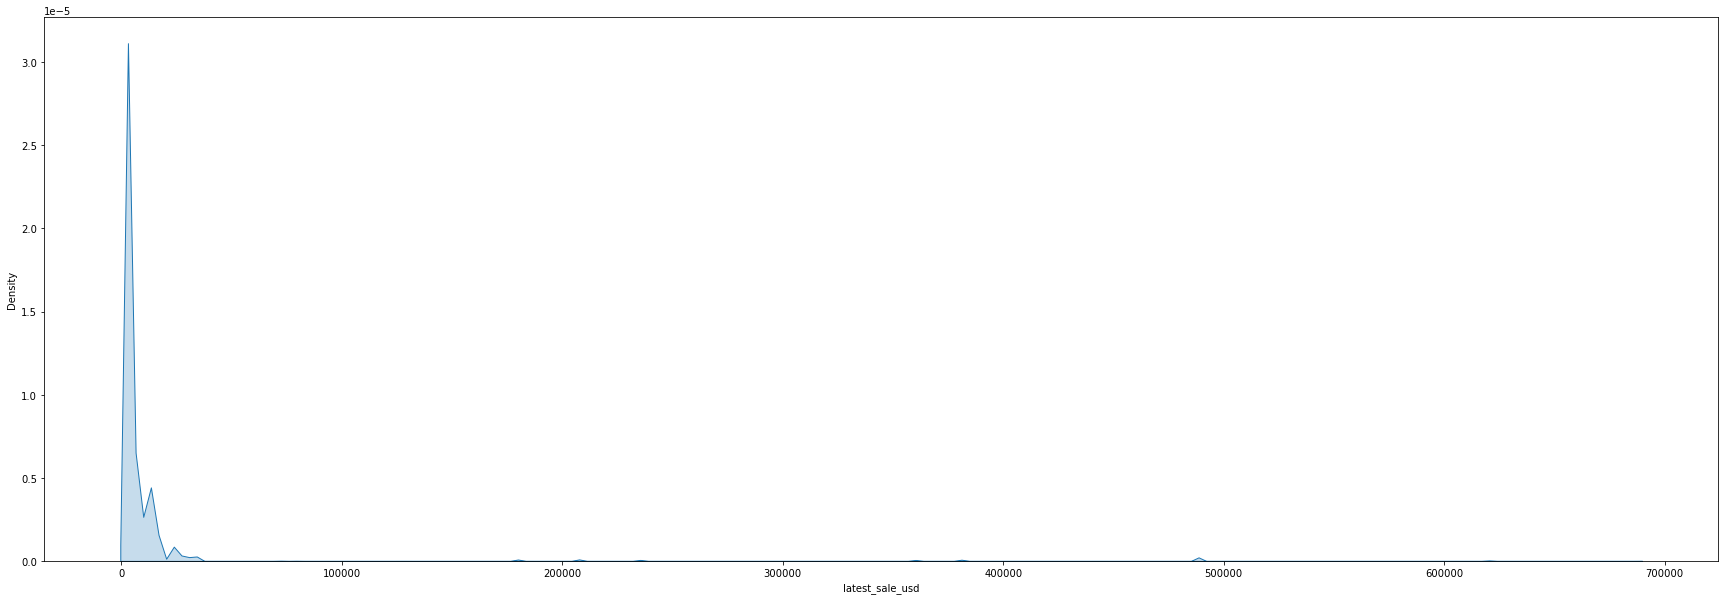

In [11]:
plt.figure(figsize = (30,10))
sns.kdeplot(elastic_df['latest_sale_usd'], bw_method=0.01, fill = True)
plt.show()

In [20]:
elastic_df['@latest_sale_timestamp']

0       2021-11-21T15:06:11
1       2021-11-21T15:06:47
2       2021-11-21T15:06:47
3       2021-11-21T15:06:47
4       2021-11-21T15:06:11
               ...         
9995    2021-11-23T18:45:47
9996    2021-11-23T18:45:02
9997    2021-11-23T18:45:02
9998    2021-11-23T18:44:47
9999    2021-11-23T18:44:47
Name: @latest_sale_timestamp, Length: 10000, dtype: object

In [10]:
import datetime
from datetime import datetime

In [13]:
datetime.fromisoformat(elastic_df['@latest_sale_timestamp'][0]).time()

datetime.time(15, 6, 11)

In [11]:
elastic_df['sale_time'] = elastic_df.apply(lambda row: 
                                      datetime.fromisoformat(row['@latest_sale_timestamp']).time().hour, axis=1)

In [25]:
elastic_df['sale_time'][0]

15

In [12]:
elastic_df.drop(['@latest_sale_timestamp'], inplace=True, axis=1)

In [16]:
elastic_df['collection_created']

0       2019-05-08T21:59:36.282454
1       2021-11-21T09:55:15.388526
2       2021-09-20T02:11:59.437808
3       2021-11-21T09:55:15.388526
4       2021-11-21T09:55:15.388526
                   ...            
9995    2021-09-02T16:24:41.860547
9996    2021-10-18T16:33:01.511379
9997    2021-10-18T16:33:01.511379
9998    2021-09-24T08:30:59.868398
9999    2021-10-15T19:16:32.231037
Name: collection_created, Length: 10000, dtype: object

In [13]:
elastic_df['collection_created_year'] = elastic_df.apply(lambda row: 
                                      datetime.fromisoformat(row['collection_created']).year, axis=1)

In [17]:
elastic_df['collection_created_year']

0       2019
1       2021
2       2021
3       2021
4       2021
        ... 
9995    2021
9996    2021
9997    2021
9998    2021
9999    2021
Name: collection_created_year, Length: 10000, dtype: int64

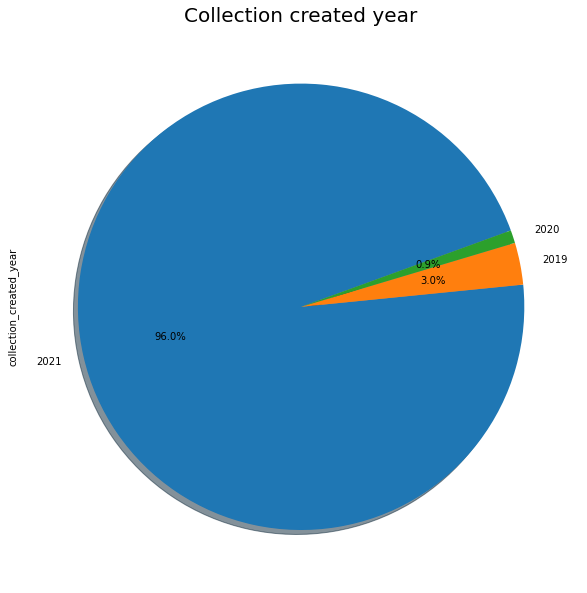

In [45]:
elastic_df['collection_created_year'].value_counts()[:10].plot.pie(figsize=(10,15), shadow=True, 
                                                 startangle=20, autopct='%1.1f%%', fontsize=10)
plt.title("Collection created year", fontsize=20)
plt.show()

In [14]:
elastic_df.drop(['collection_created_year'], inplace=True, axis=1)

In [15]:
len(elastic_df['creator'].value_counts())

1090

In [54]:
elastic_df['creator'].value_counts()[0:10]

AvarikSagaTeam                                1135
Noundles                                       487
0x3549d95f144c0cc9eb5fc29fc8b6881a84d51536     478
Feudalz-NFT                                    305
0xc00f4b8022e4dc7f086d703328247cb6adf26858     252
TheNinjaHideout                                235
0x18dd4e0eb8699ea4fee238de41ecfb95e32272f8     199
Ninja_Squad_NFT                                164
Legend_Maps                                    159
PagziTechInc                                   146
Name: creator, dtype: int64

In [20]:
len(elastic_df['collection_slug'].value_counts()) #name of the collection, short name of any collection

1146

In [19]:
elastic_df['collection_slug'].value_counts()[0:10]

avariksagauniverse        1124
kumo-x-world-residents     742
feudalz                    466
noundles                   376
zunks                      303
theninjahideout            232
sandbox                    219
ninja-squad-official       155
toyboogers                 129
robotos-official           128
Name: collection_slug, dtype: int64

In [16]:
elastic_df.drop(['creator'], inplace=True, axis=1)

In [56]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  object 
 1   collection_created      10000 non-null  object 
 2   latest_sale_usd         10000 non-null  float64
 3   description             7519 non-null   object 
 4   external_link           2952 non-null   object 
 5   twitter                 1942 non-null   object 
 6   img_path                9839 non-null   object 
 7   twitter_follower        1869 non-null   object 
 8   name                    9655 non-null   object 
 9   collection_slug         10000 non-null  object 
 10  preview_path            10000 non-null  object 
 11  collection_description  9880 non-null   object 
 12  instagram               3854 non-null   object 
 13  telegram_follower       141 non-null    object 
 14  telegram                159 non-null   

In [59]:
elastic_df['description'][0:20]

0                        `cryptomeme.eth`, an ENS name.
1                                                  None
2                                                  None
3                                                  None
4                                                  None
5                                                  None
6                                                  None
7                                                  None
8     When nounsdaos meets doodles. Not affiliated w...
9     This one-of-a-kind OG:Crystal reflects both th...
10                                                 None
11                                                 None
12    Dirty Dogs are a collection of 7,000 unique Do...
13    119m² parcel on 서울, 739m from the origin, with...
14                                                 None
15                                                 None
16                        The deity is still in hiding.
17    When nounsdaos meets doodles. Not affiliat

In [33]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,9953,0.9953
telegram_follower,9843,0.9843
telegram,9829,0.9829
twitter_follower,8008,0.8008
twitter,7930,0.7930
external_link,7299,0.7299
instagram,5485,0.5485
description,2261,0.2261
name,322,0.0322
img_path,164,0.0164


In [17]:
elastic_df['collection_description'].fillna("", inplace = True)

In [18]:
def descriptionFill(row):
    if row['description'] == None:
        return row['collection_description']
    else:
        return row['description']
        

elastic_df['description'] = elastic_df.apply(lambda row : descriptionFill(row), axis = 1)

In [23]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
instagram_follower,9953,0.9953
telegram_follower,9843,0.9843
telegram,9829,0.9829
twitter_follower,8008,0.8008
twitter,7930,0.7930
external_link,7299,0.7299
instagram,5485,0.5485
name,322,0.0322
img_path,164,0.0164
collection_description,0,0.0000


In [33]:
elastic_df['name'].head()

0                  cryptomeme.eth
1                           #2388
2    Primate Social Society #8390
3                            #979
4                            #711
Name: name, dtype: object

In [53]:
#name of one asset
print(elastic_df['name'].value_counts())

CAT BREAD                   13
BlockchainMiners             6
Ape Harmony Monster Club     5
Cyber Zombie Society         4
Orc                          4
                            ..
Paladin Panda#6718           1
World #3510                  1
Meebit #699                  1
Noundles #5785               1
SlimHood #1400               1
Name: name, Length: 9557, dtype: int64


In [66]:
elastic_df.iloc[135]

id                                                     Js4sQ30Bnd7hjRQyh96f
collection_created                               2021-03-14T04:17:45.688630
latest_sale_usd                                                   1437.3843
description               Billie Eyelash has retired from singing and ha...
external_link                                                          None
twitter                   https://cdn.syndication.twimg.com/widgets/foll...
img_path                  D:\Code\datascience\opensea_scapper\opensea_nf...
twitter_follower                                                      15867
name                                                       Crypto Perv #289
collection_slug                                                 cryptopervs
preview_path              D:\Code\datascience\opensea_scapper\opensea_nf...
collection_description    A collection of 1000 Pervs. All Pervs are uniq...
instagram                                                                  
telegram_fol

In [19]:
import re

In [22]:
#def nameNone(row):
#    if row['name'] == None:
#        return 'no name'
#    else:
#        return row['name']
        
#elastic_df['name_try'] = elastic_df.apply(lambda row : nameNone(row), axis = 1)

In [20]:
#unique name = 1/yes (as a rule unique asset has a unique name without numbers or collection's name).
#not unique name = 0/no
def unique_name(row):
    if row['name'] == None: #all missing values are 0, because these names aren't unique
        return 0
    search_number = re.search('#[0-9]', row['name']) #all names with #1234 are also not unique
    if search_number != None:
        return 0
    search_number = re.search('^[0-9]+$', row['name']) #all names with 1234 are also not unique
    if search_number != None:
        return 0
    #comparison of the name of an asset & collection's name. First we need to prepare the text 
    lowercase = row['name'].lower()
    minus = re.compile('[^a-zA-Z]|official')
    minus_case = re.sub(minus, '', lowercase)
    if row['collection_slug'] != None:
        slug = row['collection_slug'].lower()
        slug_clean = re.sub(minus, '', lowercase)
        if len(slug_clean) > 0 and slug_clean == minus_case:
            return 0
    print(row['collection_slug'], row['name'], minus_case)    
    return 1  

In [21]:
elastic_df['unique_asset'] = elastic_df.apply(lambda row : unique_name(row), axis = 1)

cryptovoxels 17 외대역동로 
ilyakazakov たまこ 
theyolkfrat  
jungle-guardian 𝕿𝖍𝖊 𝕲𝖚𝖆𝖗𝖉𝖎𝖆𝖓 
theyolkfrat  


In [69]:
elastic_df['unique_asset'].value_counts()

0    9995
1       5
Name: unique_asset, dtype: int64

In [138]:
lowercase = 'Name _Hey-Holaz??! official'.lower()
minus = re.compile('[^a-zA-Z]|official')
minus_case = re.sub(minus, '', lowercase)
print(minus_case)

nameheyholaz


In [22]:
# instagram account? yes - 1, no -0
def instAcc(row):
    if row['instagram'] == None:
        return 0
    else:
        return 1
        
elastic_df['instagram_account'] = elastic_df.apply(lambda row : instAcc(row), axis = 1)

In [28]:
elastic_df['instagram_account'].value_counts()

0    5485
1    4515
Name: instagram_account, dtype: int64

In [23]:
elastic_df['name'].fillna("", inplace = True)

In [24]:
elastic_df.drop(['instagram_follower', 'telegram_follower', 
                'telegram'], inplace=True, axis=1)

In [31]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
twitter_follower,8008,0.8008
twitter,7930,0.7930
external_link,7299,0.7299
instagram,5485,0.5485
img_path,164,0.0164
id,0,0.0000
collection_created,0,0.0000
latest_sale_usd,0,0.0000
description,0,0.0000
name,0,0.0000


In [25]:
#account? yes - 1, no -0
def twiterAcc(row):
    if row['twitter'] == None:
        return 0
    else:
        return 1
        
elastic_df['twitter_account'] = elastic_df.apply(lambda row : twiterAcc(row), axis = 1)

In [26]:
def follower_twitter(row):
    if row['twitter_follower'] == None:
        return 0
    else:
        return row['twitter_follower']
        
elastic_df['follower_twitter'] = elastic_df.apply(lambda row : follower_twitter(row), axis = 1)

In [27]:
elastic_df.drop(['twitter_follower'], inplace=True, axis=1)

In [28]:
elastic_df['twitter'].fillna("", inplace = True)
elastic_df['instagram'].fillna("", inplace = True)

In [29]:
elastic_df.drop(['collection_created', 'twitter'], inplace=True, axis=1)

In [37]:
total = elastic_df.isnull().sum().sort_values(ascending=False)
percent = (elastic_df.isnull().sum()/elastic_df.isnull().count()).sort_values(ascending=False)
missing_data = pandas.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
external_link,7299,0.7299
img_path,164,0.0164
id,0,0.0000
latest_sale_usd,0,0.0000
description,0,0.0000
name,0,0.0000
collection_slug,0,0.0000
preview_path,0,0.0000
collection_description,0,0.0000
instagram,0,0.0000


In [39]:
elastic_df['name']

0                     cryptomeme.eth
1                              #2388
2       Primate Social Society #8390
3                               #979
4                               #711
                    ...             
9995             Tie Dye Ninja #3839
9996                   Robopet #8636
9997                   Robopet #6194
9998                       NUT #3680
9999                  SlimHood #1400
Name: name, Length: 10000, dtype: object

In [40]:
elastic_df['collection_slug']

0                                   ens
1                               feudalz
2       primate-social-society-official
3                               feudalz
4                               feudalz
                     ...               
9995                     tie-dye-ninjas
9996                           robopets
9997                           robopets
9998                       bofadeeznuts
9999                          slimhoods
Name: collection_slug, Length: 10000, dtype: object

In [41]:
elastic_df['description']

0                          `cryptomeme.eth`, an ENS name.
1       Feudalz emerged to protect their Peasants. Whe...
2       The Primate Social Society is a sophisticated ...
3       Feudalz emerged to protect their Peasants. Whe...
4       Feudalz emerged to protect their Peasants. Whe...
                              ...                        
9995    The Tie Dye Ninjas are a collection of 7,777 u...
9996    Robopets are loyal companions to all Robotos w...
9997    Robopets are loyal companions to all Robotos w...
9998                                            NUT #3680
9999    They all wear hoods, but each SlimHood is unique.
Name: description, Length: 10000, dtype: object

## Text columns preparation

In [107]:
elastic_df['collection_description'][10:40]

10    Vol. 1 of MetaTravelers features 7777 avatars ...
11    Feudalz emerged to protect their Peasants. Whe...
12    Dirty Dogs is a 7,000 randomly generated pack ...
13    A virtual world on the Ethereum blockchain. Bu...
14    Feudalz emerged to protect their Peasants. Whe...
15    Sappy Seals is community-led project focused o...
16    Ánthrōpos métron -Man is the measure of all th...
17    Noundles is based on Nouns with a twist in sty...
18    Feudalz emerged to protect their Peasants. Whe...
19    Feudalz emerged to protect their Peasants. Whe...
20    Minting Now on https://www.toyboogers.io\r\nPr...
21    Feudalz emerged to protect their Peasants. Whe...
22    Feudalz emerged to protect their Peasants. Whe...
23                  Metasaurs Mystery Chests by Dr. DMT
24    Feudalz emerged to protect their Peasants. Whe...
25    Feudalz emerged to protect their Peasants. Whe...
26    Feudalz emerged to protect their Peasants. Whe...
27    The Surreals are a collection of 10,000 ha

In [30]:
#remove everything except characters and white spaces.
def clean_text(text):
    # matches: www.gg-io.lkl?q=tz#jjk + opensea.io/collection/ape123 + medium.com/cryptopoop + sub.domain.org
    clean_link = re.compile(r'(^|\s)(https?:\/\/)?(www\.)?[\w\-\.]+\.(com|io|eth|org|gg|de)(\/[\w\.\-\/#\?\=]*)?(\s|$)')
    clean_files = re.compile('[\w-]*\.(png|jpg|tif|obj|svg|gif|js|jpeg)')
    clean = re.compile('[^a-zA-Z \.,\?!:]+')
    clean_missingspace = re.compile('(\w)\.(\w)')
    clean_doublespace = re.compile('\s\s+')
    clean_puncts = re.compile('\.\.+')
    clean_text = re.sub(clean_link, ' ', text)
    clean_text = re.sub(clean_files, '', clean_text)
    clean_text = re.sub(clean, ' ', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_puncts, '.', clean_text)
    clean_text = re.sub(clean_doublespace, ' ', clean_text)

    return clean_text

In [48]:
clean_text('more... Primate.Social.Society .png: #8390?!')

'more. Primate. Social. Society : ?!'

In [38]:
t = elastic_df['collection_description'].apply(lambda text: clean_text(text))
#t[t.str.contains('thief')]
t[t.re('thief')]

Series([], Name: collection_description, dtype: object)

In [35]:
elastic_df['collection_description'] = elastic_df['collection_description'].apply(lambda text: 
                                                                                  clean_text(text))
elastic_df['description'] = elastic_df['description'].apply(lambda text: clean_text(text))
elastic_df['name'] = elastic_df['name'].apply(lambda text: clean_text(text))

In [58]:
elastic_df['collection_description'].str.contains('fortunes.the')

0       [ethereum, name, service, en, domain, secure, ...
1       [feudalz, emerge, protect, peasant, system, ru...
2       [primate, social, society, sophisticated, coll...
3       [feudalz, emerge, protect, peasant, system, ru...
4       [feudalz, emerge, protect, peasant, system, ru...
                              ...                        
9995    [unique, tie, dye, ninja, nfts, honor, art, mu...
9996    [robopets, collection, algorithmically, genera...
9997    [robopets, collection, algorithmically, genera...
9998    [everyone, hodls, deez, nut, co, casino, arcad...
9999                       [wear, hood, slimhood, unique]
Name: collection_description, Length: 10000, dtype: object

In [36]:
elastic_df['word_count_coll_desc'] = elastic_df["collection_description"].apply(lambda x: len(str(x).split(" ")))

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='word_count_coll_desc'>

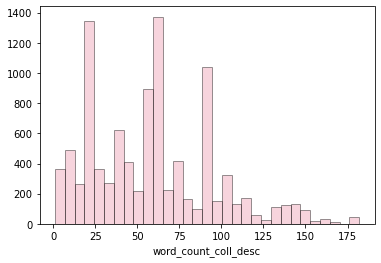

In [37]:
sns.distplot(elastic_df['word_count_coll_desc'], hist=True, kde=False, color = '#ec95ac',
             hist_kws={'edgecolor':'black'})

In [38]:
elastic_df['word_count_descr'] = elastic_df["description"].apply(lambda x: len(str(x).split(" ")))

<AxesSubplot:xlabel='word_count_descr'>

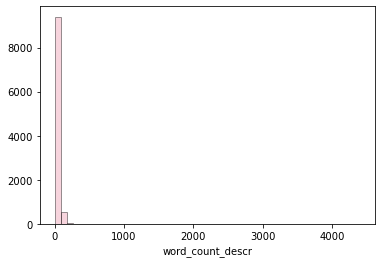

In [62]:
sns.distplot(elastic_df['word_count_descr'], hist=True, kde=False, color = '#ec95ac',
             hist_kws={'edgecolor':'black'})

## Lemmatisation (NLTK)

In [39]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import pos_tag

In [77]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [85]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [40]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') #filter out stop words
tag_dict = {
    "J": wordnet.ADJ,
    "N": wordnet.NOUN,
    "V": wordnet.VERB,
    "R": wordnet.ADV
}
def lemma_text(text):
    new_text_array = []
    sentences = sent_tokenize(text.lower(), language = 'english')
    for sent in sentences:
        tokens = word_tokenize(sent, language = 'english')
        tok_pos = nltk.pos_tag(tokens)
        for tok, pos in tok_pos:
            if tok in stop_words:
                continue
            tok_type = pos[0].upper() # gets N for noun
            if tok_type in ['.', ',', ':']: # ignore punctuation
                continue
                
            mapped_type = tag_dict.get(tok_type, wordnet.NOUN) # default NOUN
            if tok.startswith('.'):
                tok = tok[1:]   
            new_text_array.append(lemmatizer.lemmatize(tok, mapped_type))
    return new_text_array #' '.join(new_text_array)

In [94]:
lemma_text('Ethereum Name. Service, ENS .domains are secure: bullshit rules! Hello.')

['ethereum',
 'name',
 'service',
 'ens',
 'domain',
 'secure',
 'bullshit',
 'rule',
 'hello']

In [41]:
elastic_df['collection_description'] = elastic_df['collection_description'].apply(lemma_text)
elastic_df['description'] = elastic_df['description'].apply(lemma_text)
elastic_df['name'] = elastic_df['name'].apply(lemma_text)

## Word2Vec
 https://aegis4048.github.io/understanding_multi-dimensionality_in_vector_space_modeling
 https://www.kaggle.com/dmitryyemelyanov/word-vector-dimensionality-reduction-with-t-sne

In [42]:
from gensim.models import Word2Vec 
import multiprocessing
import gensim
from time import time
from gensim.models.phrases import Phrases, Phraser
from time import time

In [43]:
t = time()
w2v = gensim.models.Word2Vec(elastic_df['collection_description'] + elastic_df['description'] +
                             elastic_df['name'], 
                             min_count = 1, 
                             negative=2, 
                             size = 100,
                             window = 5, 
                             sg = 1, 
                             workers=14)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.04 mins


In [44]:
print(w2v)

Word2Vec(vocab=11179, size=100, alpha=0.025)


In [45]:
# summarise vocabulary
words = list(w2v.wv.vocab)
print(words[5:10])

['secure', 'decentralized', 'world', 'provide', 'way']


In [46]:
w2v.wv.most_similar('ape',topn=5)

[('dopest', 0.6616077423095703),
 ('harmony', 0.6461648941040039),
 ('likeness', 0.6381094455718994),
 ('division', 0.6283000111579895),
 ('yatch', 0.6271748542785645)]

In [47]:
list(filter(lambda x: x.find('.') >= 0, words))

['dr.',
 'st.',
 's.',
 'co.',
 'k.',
 'a.',
 'k.a',
 'p.e.',
 't.',
 'mr.',
 'jr.',
 'r.',
 'o.y',
 'give.a',
 'ok.',
 'n.',
 'e.',
 'g.',
 'fortunes.the',
 'd.',
 'rulers.the',
 'just.thief',
 'x.',
 'vs.',
 'a.s.',
 'l.',
 'ft.',
 'c.',
 'e.hoe',
 'ore.',
 'a.m.',
 'p.',
 'wow.just',
 'you.the',
 'i.',
 'gen.',
 'm.',
 't.a',
 'ltd.',
 'i.n',
 'ave.',
 'nuts.']

In [80]:
'.strin.gjjj.j'.find('.') >= 0

True

## Visualization: t-SNE

In [68]:
X = w2v[w2v.wv.vocab]

<ipython-input-68-2839f6b6f643>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = w2v[w2v.wv.vocab]


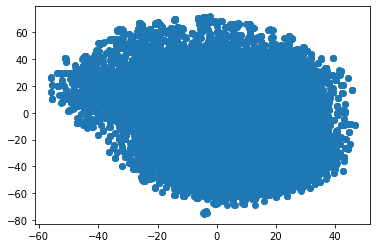

In [69]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50) #perplexity=30 by default, suggested values are between 6 and 60
Y = tsne.fit_transform(X[1000:])
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

## Imgages Preparation for PyTorch 

In [16]:
ids = ['c44COn0BHA1xYJHHzdGZ', 'z46BOn0BHA1xYJHHgttE', 'io5MOX0BHA1xYJHHrMnG']
# response = requests.get(url=f'http://localhost:9200/opensea/_doc/{id}')
# response.json()

In [12]:
from PIL import Image
import torch

In [18]:
image_folder = '..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\preview\\'

imgs = []
for id in ids:
    filename = image_folder + id + '_noext.png'
    imgs.append(Image.open(filename))

#imgs[1]

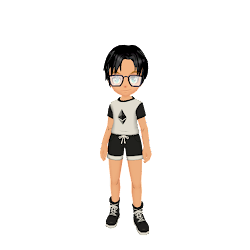

In [188]:
imgs[2]

https://github.com/born-2learn/pytorch-imagesegmentation/blob/master/imagesegmentation.ipynb
https://sparrow.dev/torchvision-transforms/

Normalizing images. In PyTorch, we can normalize images with torchvision, a utility that provides convenient preprocessing transformations. 

Text(0.5, 1.0, 'distribution of pixels')

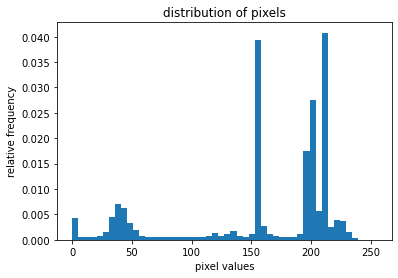

In [23]:
plt.hist(np.array(imgs[1]).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")
#https://sparrow.dev/pytorch-normalize/

Text(0.5, 1.0, 'distribution of pixels')

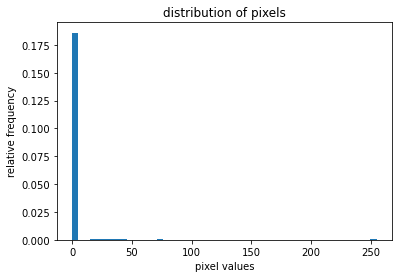

In [24]:
plt.hist(np.array(imgs[0]).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

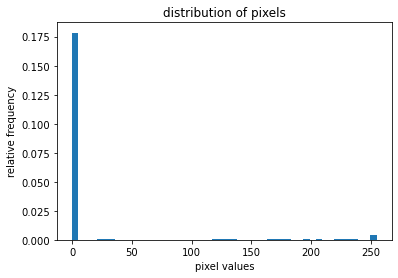

In [25]:
plt.hist(np.array(imgs[2]).ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [26]:
import torchvision.transforms as T
import io

In [28]:
#preprocessing and normalizing
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

In [29]:
imgs_norm = []
for img in imgs:
    imgs_norm.append(trf(img.convert('RGB')))

In [103]:
#RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0
#It seems normalize raises the shape mismatch error.
#It seems that I might have used 3 values for the mean and std in Normalize while your input contains 4 channels
# FUTURE reading: https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

[tensor([[[-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0494, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -1.9295, -2.0494, -2.0323],
          ...,
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323]],
 
         [[-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9657, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.8431, -1.9657, -1.9482],
          ...,
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482],
          [-1.9482, -1.9482, -1.9482,  ..., -1.9482, -1.9482, -1.9482]],
 
         [[-1.7173, -1.7173, -1.7173,  ..., -1.7173, -1.7173, -1.7173],
          [-1.7173, -1.7173,